# Build 'buildings-extract-coco-hf' Dataset

In [ ]:
# ----------------------------------------------------------------------------------------
# Load local dataset and pre-process
# ----------------------------------------------------------------------------------------

# Probably not needed since it can be resized on the fly on the processor later on
# Still saves some computation power at least

import os
import json
import shutil

from PIL import Image
from tqdm import tqdm
from pathlib import Path

def resize_images_json(images_dir, new_images_dir, json_file, new_json_file, new_size=(512, 512)):
    
    # Create directory
    os.makedirs(new_images_dir, exist_ok=True)
    
    # --- LOAD COCO JSON ---
    with open(json_file, 'r') as f:
        coco = json.load(f)

    # --- RESIZE IMAGES AND UPDATE ANNOTATIONS ---
    for img_info in tqdm(coco['images'], total=len(coco['images'])):
        file_name = img_info['file_name'].split("/")[1]
        img_path = os.path.join(images_dir, file_name)
        img = Image.open(img_path)
        old_width, old_height = img.size

        # Resize image
        new_img_path = os.path.join(new_images_dir, file_name)
        img_resized = img.resize(new_size)
        img_resized.save(new_img_path, quality=95, optimize=True)

        # Compute scale factors
        scale_x = new_size[0] / old_width
        scale_y = new_size[1] / old_height

        # Update image info in JSON
        img_info['file_name'] = new_img_path
        img_info['width'], img_info['height'] = new_size


        # Update annotations for this image
        for ann in coco['annotations']:
            if ann['image_id'] != img_info['id']:
                continue

            # Update bbox: [x_min, y_min, width, height]
            x, y, w, h = ann['bbox']
            ann['bbox'] = [
                x * scale_x,
                y * scale_y,
                w * scale_x,
                h * scale_y
            ]

            # Update segmentation polygons
            for seg in ann['segmentation']:
                for i in range(0, len(seg), 2):
                    seg[i] *= scale_x       # x
                    seg[i+1] *= scale_y     # y

    # --- SAVE UPDATED JSON ---
    with open(new_json_file, 'w') as f:
        json.dump(coco, f)

    print(f"Resized {len(coco['images'])} images to {new_size} from '{images_dir}' -> '{new_images_dir}'")
    print(f"Updated '{json_file}' -> '{new_json_file}'")

DATASET_DIR = Path("./datasets/building-extraction-generalization-2024")
NEW_DATASET_DIR = Path("./datasets/buildings-extraction-coco-hf")
SIZE = 512

# Resize train and val
for split in ["train", "val"]:
    resize_images_json(
        images_dir=DATASET_DIR / f"{split}/image",
        new_images_dir=NEW_DATASET_DIR / f"{split}/image_{SIZE}",
        json_file=DATASET_DIR / f"{split}/{split}.json",
        new_json_file=NEW_DATASET_DIR / f"{split}/{split}_{SIZE}.json",
        new_size=(SIZE, SIZE)
    )

# Just copy the test images
test_images_dir = DATASET_DIR / f"test/image"
new_test_images_dir = NEW_DATASET_DIR / f"test/image"

os.makedirs(new_test_images_dir, exist_ok=True)

for filename in tqdm(os.listdir(test_images_dir), total=len(os.listdir(test_images_dir))):
    src_file = os.path.join(test_images_dir, filename)
    dst_file = os.path.join(new_test_images_dir, filename)
    shutil.copy2(src_file, dst_file)
print(f"Copied {len(os.listdir(test_images_dir))} images from '{test_images_dir}' -> '{new_test_images_dir}'")

In [ ]:
# ----------------------------------------------------------------------------------------
# Convert resized local dataset to HF dataset
# ----------------------------------------------------------------------------------------

# From the original buildings-extraction dataset all train and val images and annotations
# were resized to a standard size (512, 512)
import os

import numpy as np
import supervision as sv

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
from pycocotools.coco import COCO
from datasets import Dataset, DatasetDict, Image as ImageHF

def annotations_to_polygons_array(annotations):
    """
    Convert annotations segments to polygons array with the
    expected sv.polygon_to_mask format.
    """
    polygons = []
    for ann in annotations:
        segms = ann.get("segmentation", [])
        for poly in segms:
            if len(poly) < 6:  # ignore invalid polygons
                continue
            pts = np.array(poly, dtype=np.int32).reshape((-1, 2))
            polygons.append(pts)
    return polygons

def coco_to_hf_dataset(coco_ann_file, images_dir, annotations_dir):
    """ 
    Convert a COCO annotation dataset to a HF dataset, by creating the semantic and instance
    segmentation mask annotations from the segments annotations.
    """

    # Create annotation directory
    os.makedirs(annotations_dir, exist_ok=True)
    
    coco = COCO(coco_ann_file)

    # --- Images ---
    images = coco.loadImgs(coco.getImgIds())  # list of dicts: {height, width, id, file_name, ...}

    # --- Paths ---
    pil_images = [str(images_dir / Path(coco.loadImgs(img_id)[0]["file_name"]).name) for img_id in coco.getImgIds()]

    # --- Annotations ---
    # Group annotations by image_id
    anns_by_image = defaultdict(list)
    for ann in coco.loadAnns(coco.getAnnIds()):
        anns_by_image[ann["image_id"]].append(ann)

    # Make sure annotations are in the same order as images
    annotations_per_image = [anns_by_image[img["id"]] for img in images]

    pil_annotations = []
    for anns, img_id in tqdm(zip(annotations_per_image, coco.getImgIds()), total=len(annotations_per_image)):
        
        img_info = coco.loadImgs(img_id)[0]
        img_width, img_height = img_info["width"], img_info["height"]
        ann_path = annotations_dir / f"{Path(img_info['file_name']).stem}.png" # To not lose quality

        # Load polygons
        polygons = annotations_to_polygons_array(anns)

        # Semantic labels per instance
        categories = [ann["category_id"] for ann in anns]  

        # Polygons to Instance Segmentation Masks
        masks = np.array([sv.polygon_to_mask(p,(img_width, img_height)) for p in polygons])

        # Initialize combined mask (0 = background)
        instance_seg = np.zeros_like(masks[0], dtype=np.uint8)

        # Polygons to Instance Segmentation Masks
        masks = np.array([sv.polygon_to_mask(p, (img_width, img_height)) for p in polygons])

        # Initialize combined instance mask (0 = background)
        instance_seg = np.zeros_like(masks[0], dtype=np.uint8)
        semantic_seg = np.zeros_like(masks[0], dtype=np.uint8)

        # Assign unique instance IDs and semantic labels
        for i, (m, cat_id) in enumerate(zip(masks, categories), start=1):
            semantic_seg[m == 1] = cat_id + 1   # semantic class IDs -> 0 is for background
            instance_seg[m == 1] = i            # instance IDs

        # Create an empty RGB image
        rgb_img = np.zeros((instance_seg.shape[0], instance_seg.shape[1], 3), dtype=np.uint8)

        # Assign the instance_seg to the Red channel
        rgb_img[:, :, 0] = semantic_seg  # 0 = Red channel

        # Assign the instance_seg to the Green channel
        rgb_img[:, :, 1] = instance_seg  # 1 = Green channel

        # Convert to PIL Image and save
        im = Image.fromarray(rgb_img)
        im.save(ann_path)
        pil_annotations.append(str(ann_path))

    return Dataset.from_dict({
        "image_info": images,
        "annotations": annotations_per_image,
        "PIL_image": pil_images,
        "PIL_annotation": pil_annotations
    })

# Paths
DATASET_LOCAL_PATH = Path("./datasets/buildings-extraction-coco-hf/")

train_coco_ann_file = DATASET_LOCAL_PATH / "train/train_512.json"
train_images_dir = DATASET_LOCAL_PATH / "train/image_512"
train_annotations_dir = DATASET_LOCAL_PATH / "train/annotations_512"

val_coco_ann_file = DATASET_LOCAL_PATH / "val/val_512.json"
val_images_dir = DATASET_LOCAL_PATH / "val/image_512"
val_annotations_dir = DATASET_LOCAL_PATH / "val/annotations_512"

test_images_dir = DATASET_LOCAL_PATH / "test/image"

train_ds = coco_to_hf_dataset(train_coco_ann_file, train_images_dir, train_annotations_dir)

val_ds = coco_to_hf_dataset(val_coco_ann_file, val_images_dir, val_annotations_dir)

num_test = len(os.listdir(test_images_dir))
test_images_path = sorted(os.listdir(test_images_dir))
test_ds = Dataset.from_dict({
    "image_info": [{"file_name": str(test_images_dir / test_images_path[i]), "height": 500, "width": 500, "id": i} for i in range(num_test)],   # Placeholder
    "annotations": [[{"id": 0, "image_id": i, "category_id": 0, "bbox": [0.0], "area": 0, "iscrowd": 0, "segmentation": [[0.0]]}] for i in range(num_test)],
    "PIL_image": [str(test_images_dir / path) for path in sorted(os.listdir(test_images_dir))],
    "PIL_annotation": [None for _ in range(num_test)],
})

dataset = DatasetDict({
    "train": train_ds,
    "val": val_ds,
    "test": test_ds
})

dataset = dataset.cast_column("PIL_image", ImageHF())
dataset = dataset.cast_column("PIL_annotation", ImageHF())

label2id = {"building": 0}  # Start at 0 in Mask2Former
id2label = {0: "building"}  # Start at 0 in Mask2Former

dataset

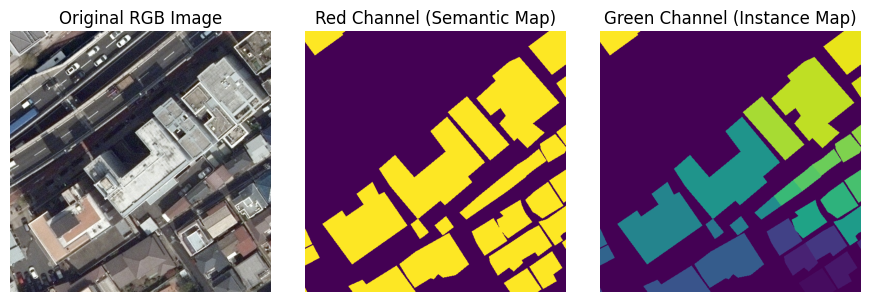

Classes:  [0 1]
Instances:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [2]:
# Quick test
import numpy as np
import matplotlib.pyplot as plt

idx = 0

training_example = dataset["train"][idx]

# Convert PIL images to numpy arrays
original_img = np.array(training_example["PIL_image"], dtype=np.uint8)
annotation_img = np.array(training_example["PIL_annotation"], dtype=np.uint8)

# Extract channels
red_channel = annotation_img[..., 0]   # semantic map stored in red
green_channel = annotation_img[..., 1] # instance map in green

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(original_img)
axes[0].set_title("Original RGB Image")
axes[0].axis("off")

axes[1].imshow(red_channel)
axes[1].set_title("Red Channel (Semantic Map)")
axes[1].axis("off")

axes[2].imshow(green_channel)
axes[2].set_title("Green Channel (Instance Map)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

print("Classes: ", np.unique(red_channel))
print("Instances: ", np.unique(green_channel))


In [ ]:
# ----------------------------------------------------------------------------------------
# Upload to HuggingFace HUB
# ----------------------------------------------------------------------------------------
from huggingface_hub import login

login()

dataset.push_to_hub("buildings-extraction-coco-hf", private=False)

In [1]:
# ---------------------------------------------
# Load Dataset from HUB
# ----------------------------------------------
from datasets import load_dataset

label2id = {"building": 0}  # Start at 0 in Mask2Former
id2label = {0: "building"}  # Start at 0 in Mask2Former

# From now on always load this dataset (can delete local folders for space if needed)
dataset = load_dataset("tomascanivari/buildings-extraction-coco-hf")
dataset

DatasetDict({
    train: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 3784
    })
    val: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 933
    })
    test: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 1000
    })
})

In [3]:
# ----------------------------------------------------------------------------------------
# Compare COCO annotation number of polygons to extracted from instance mask
# ----------------------------------------------------------------------------------------
from tqdm import tqdm

def verify_polygons_coco_mask(dataset, splits):
    
    for split in splits:
        coco_polygons = 0
        mask_polygons = 0
        
        for example in tqdm(dataset[split]):
            coco_polygons += len(example["annotations"])

            # Get the PIL annotation
            annotation = np.array(example["PIL_annotation"], dtype=np.uint8)

            # Get Semantic Map (Red channel) & Instance Map (Green chanel)
            semantic_map = annotation[:,:,0]
            instance_map = annotation[:,:,1]

            mask_polygons += len(np.unique(instance_map)) - 1

        print(f"{split.capitalize()} Split:")
        print(f"COCO Polygons: {coco_polygons} | MASK Polygons: {mask_polygons}\n")

verify_polygons_coco_mask(dataset, ["train", "val"])


100%|██████████| 3784/3784 [00:29<00:00, 129.45it/s]


Train Split:
COCO Polygons: 148983 | MASK Polygons: 148846



100%|██████████| 933/933 [00:07<00:00, 127.74it/s]

Val Split:
COCO Polygons: 37713 | MASK Polygons: 37674



# Summer Dataset Preparation
 
Trying to add instances to our dataset to better generalize and possibly improve the test
set performance (did not work, the distance on this images was different) (can skip)

In [ ]:
# ----------------------------------------------------------------------------------------
# Convert local dataset to HF dataset
# ----------------------------------------------------------------------------------------

# From the original buildings-extraction dataset all train and val images and annotations
# were resized to a standard size (512, 512)
import os

import numpy as np
import supervision as sv

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
from pycocotools.coco import COCO
from datasets import Dataset, DatasetDict, Image as ImageHF

def annotations_to_polygons_array(annotations):
        polygons = []
        for ann in annotations:
            segms = ann.get("segmentation", [])
            for poly in segms:
                if len(poly) < 6:  # ignore invalid polygons
                    continue
                pts = np.array(poly, dtype=np.int32).reshape((-1, 2))
                polygons.append(pts)
        return polygons

def coco_to_hf_dataset(coco_ann_file, images_dir, annotations_dir):
    
    # Create annotation directory
    os.makedirs(annotations_dir, exist_ok=True)
    
    coco = COCO(coco_ann_file)

    # --- Images ---
    images = coco.loadImgs(coco.getImgIds())  # list of dicts: {height, width, id, file_name, ...}

    # --- Paths ---
    pil_images = [str(images_dir / Path(coco.loadImgs(img_id)[0]["file_name"]).name) for img_id in coco.getImgIds()]

    # --- Annotations ---
    # Group annotations by image_id
    anns_by_image = defaultdict(list)
    for ann in coco.loadAnns(coco.getAnnIds()):
        anns_by_image[ann["image_id"]].append(ann)

    # Make sure annotations are in the same order as images
    annotations_per_image = [anns_by_image[img["id"]] for img in images]

    pil_annotations = []
    for anns, img_id in tqdm(zip(annotations_per_image, coco.getImgIds()), total=len(annotations_per_image)):
        
        img_info = coco.loadImgs(img_id)[0]
        img_width, img_height = img_info["width"], img_info["height"]
        ann_path = annotations_dir / f"{Path(img_info['file_name']).stem}.png" # To not lose quality          

        # Load polygons
        polygons = annotations_to_polygons_array(anns)

        # Semantic labels per instance
        categories = [ann["category_id"] for ann in anns]  

        # Polygons to Instance Segmentation Masks
        masks = np.array([sv.polygon_to_mask(p, (img_width, img_height)) for p in polygons])

        # Initialize combined instance mask (0 = background)
        instance_seg = np.zeros((img_width, img_height), dtype=np.uint8)
        semantic_seg = np.zeros((img_width, img_height), dtype=np.uint8)

        # Assign unique instance IDs and semantic labels
        for i, (m, cat_id) in enumerate(zip(masks, categories), start=1):
            semantic_seg[m == 1] = 1   # semantic class IDs -> 0 is for background
            instance_seg[m == 1] = i   # instance IDs

        # Create an empty RGB image
        rgb_img = np.zeros((img_width, img_height, 3), dtype=np.uint8)

        # Assign the instance_seg to the Red channel
        rgb_img[:, :, 0] = semantic_seg  # 0 = Red channel

        # Assign the instance_seg to the Green channel
        rgb_img[:, :, 1] = instance_seg  # 1 = Green channel

        # Convert to PIL Image and save
        im = Image.fromarray(rgb_img)
        im.save(ann_path)
        pil_annotations.append(str(ann_path))

    return Dataset.from_dict({
        "image_info": images,
        "annotations": annotations_per_image,
        "PIL_image": pil_images,
        "PIL_annotation": pil_annotations
    })

# Paths
DATASET_LOCAL_PATH = Path("./datasets/summer-v14.v2i.coco-segmentation/")

train_coco_ann_file = DATASET_LOCAL_PATH / "train/train.json"
train_images_dir = DATASET_LOCAL_PATH / "train/image"
train_annotations_dir = DATASET_LOCAL_PATH / "train/annotations"

train_ds = coco_to_hf_dataset(train_coco_ann_file, train_images_dir, train_annotations_dir)

# Split: 80% train, 20% validation
split_ds = train_ds.train_test_split(test_size=0.2, seed=42)

train_ds = split_ds["train"]
val_ds= split_ds["test"]

dataset = DatasetDict({
    "train": train_ds,
    "val": val_ds
})

dataset = dataset.cast_column("PIL_image", ImageHF())
dataset = dataset.cast_column("PIL_annotation", ImageHF())

label2id = {"building": 0}  # Start at 0 in Mask2Former
id2label = {0: "building"}  # Start at 0 in Mask2Former

dataset

In [ ]:
# Quick test
import numpy as np
import matplotlib.pyplot as plt

idx = 0

training_example = dataset["train"][idx]

# Convert PIL images to numpy arrays
original_img = np.array(training_example["PIL_image"], dtype=np.uint8)
annotation_img = np.array(training_example["PIL_annotation"], dtype=np.uint8)

# Extract channels
red_channel = annotation_img[..., 0]   # semantic map stored in red
green_channel = annotation_img[..., 1] # instance map in green

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(original_img)
axes[0].set_title("Original RGB Image")
axes[0].axis("off")

axes[1].imshow(red_channel)
axes[1].set_title("Red Channel (Semantic Map)")
axes[1].axis("off")

axes[2].imshow(green_channel)
axes[2].set_title("Green Channel (Instance Map)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

print("Classes: ", np.unique(red_channel))
print("Instances: ", np.unique(green_channel))

# Keep in mind no annotations for idx = 0

In [ ]:
# Quick test
import numpy as np
import matplotlib.pyplot as plt

idx = 6

training_example = dataset["train"][idx]

# Convert PIL images to numpy arrays
original_img = np.array(training_example["PIL_image"], dtype=np.uint8)
annotation_img = np.array(training_example["PIL_annotation"], dtype=np.uint8)

# Extract channels
red_channel = annotation_img[..., 0]   # semantic map stored in red
green_channel = annotation_img[..., 1] # instance map in green

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(original_img)
axes[0].set_title("Original RGB Image")
axes[0].axis("off")

axes[1].imshow(red_channel)
axes[1].set_title("Red Channel (Semantic Map)")
axes[1].axis("off")

axes[2].imshow(green_channel)
axes[2].set_title("Green Channel (Instance Map)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

print("Classes: ", np.unique(red_channel))
print("Instances: ", np.unique(green_channel))

In [ ]:
# ----------------------------------------------------------------------------------------
# Upload to HuggingFace HUB
# ----------------------------------------------------------------------------------------
from huggingface_hub import login

login()

dataset.push_to_hub("summer-buildings-extraction-coco-hf", private=False)

# Complete Dataset

Merging the other two (same reason as above, can skip)

In [ ]:
# ---------------------------------------------
# Load Datasets from HUB
# ----------------------------------------------
from datasets import load_dataset, concatenate_datasets, DatasetDict

label2id = {"building": 0}  # Start at 0 in Mask2Former
id2label = {0: "building"}  # Start at 0 in Mask2Former

# From now on always load this dataset (can delete local folders for space if needed)
base_dataset = load_dataset("tomascanivari/buildings-extraction-coco-hf")
summer_dataset = load_dataset("tomascanivari/summer-buildings-extraction-coco-hf")

# Align schema of base to summer dataset (allow images with no segments)
base_dataset["train"] = base_dataset["train"].cast(summer_dataset["train"].features)
base_dataset["val"] = base_dataset["val"].cast(summer_dataset["train"].features)
base_dataset["test"] = base_dataset["test"].cast(summer_dataset["train"].features)

dataset = DatasetDict({
    "train": concatenate_datasets([base_dataset["train"], summer_dataset["train"]]),
    "val": concatenate_datasets([base_dataset["val"], summer_dataset["val"]]),
    "test": base_dataset["test"]
})

dataset

In [ ]:
# ----------------------------------------------------------------------------------------
# Upload to HuggingFace HUB
# ----------------------------------------------------------------------------------------
from huggingface_hub import login

login()

dataset.push_to_hub("complete-buildings-extraction-coco-hf", private=False)